In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',time='11:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.QeCalculator(rr,activate_BeeOND=True) #,skip=False,clean_restart=False
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': '11:59:00',
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'pw.x',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True}

In [5]:
# RunRules for m100
nodes = 1
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_AlNWS2',
                memory='120GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.QeCalculator(rr)
#code.global_options()

# DFT analysis of the bulk MoS$_2$

This notebook contains the DFT analysis of the bulk MoS$_2$ performed with QuantumESPRESSO

## Lattice properties and atomic positions

We start from the input file generated from the inputs provided by Maurizia Palumno

In [5]:
inp = I.PwInput(file='Bulk_input_files/MoS2_2H_pbe_bulk.in')
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'restart_mode': "'from_scratch'",
  'wf_collect': '.true.'},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 4,
  'celldm(1)': 5.9998,
  'celldm(3)': 3.998,
  'nat': 6,
  'ntyp': 2,
  'noncolin': '.true.',
  'lspinorb': '.true.',
  'ecutwfc': 60},
 'electrons': {'diago_full_acc': '.false.', 'mixing_beta': 0.7},
 'ions': {},
 'cell': {},
 'atomic_species': {'S': [32.065, 'S-fr.out'], 'Mo': [183.84, 'Mo-fr.out']},
 'atomic_positions': {'type': '(crystal)',
  'values': [['Mo', [0.333333, 0.666667, 0.25]],
   ['Mo', [0.666667, 0.333333, 0.75]],
   ['S', [0.666667, 0.333333, 0.3768113548]],
   ['S', [0.333333, 0.666667, 0.8768113548]],
   ['S', [0.666667, 0.333333, 0.1231886452]],
   ['S', [0.333333, 0.666667, 0.6231886452]]]},
 'kpoints': {'type': 'automatic',
  'values': ([12.0, 12.0, 2.0], [0.0, 0.0, 0.0])},
 'cell_parameters': {},
 'file': 'Bulk_input_files/MoS2_2H_pbe_bulk.in

and we read the relevant lattice and atomic parameters from the file

In [20]:
alat = inp['system']['celldm(1)']
celldm3 = inp['system']['celldm(3)']
lattice = alat*np.array([[1,0,0],[-1./2.,np.sqrt(3)/2.,0],[0,0,celldm3]])
atoms_cryst = inp['atomic_positions']['values'] # in crystal coordinates

We convert the atomic positions in cartesian coordinates and we plot the 
lattice

In [21]:
from mppi.Utilities import LatticeUtils as LatU

In [29]:
atoms_cart = []
for atom in atoms_cryst:
    atoms_cart.append([atom[0],LatU.convert_to_cartesian(lattice,atom[1])])
atoms_cart

[['Mo', array([-2.99990000e-06,  3.46398788e+00,  5.99680010e+00])],
 ['Mo', array([ 2.999903  ,  1.73199134, 17.9904003 ])],
 ['S', array([2.999903  , 1.73199134, 9.03864948])],
 ['S', array([-2.99990000e-06,  3.46398788e+00,  2.10322497e+01])],
 ['S', array([2.999903  , 1.73199134, 2.95495072])],
 ['S', array([-2.99990000e-06,  3.46398788e+00,  1.49485509e+01])]]

In [30]:
positions = LL.build_lattice(lattice,atoms_cart,8,8,2)
#positions

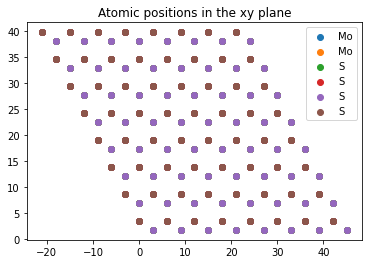

In [31]:
for pos in positions:
    plt.scatter(pos[1],pos[2],label=pos[0])
plt.title('Atomic positions in the xy plane',size=12)
plt.legend()

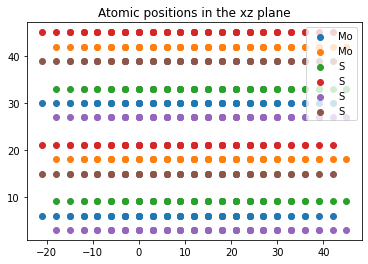

In [32]:
for pos in positions:
    plt.scatter(pos[1],pos[3],label=pos[0])
plt.title('Atomic positions in the xz plane',size=12)
plt.legend()

## GS Analysis

We perform some convergence tests for the energy cutoff of the wavefunction and for the lattice parameters
in order to find a converged ground state.

At this stage we do not test over the k-points sampling, so the value 12x12x2 provided in the original input
file is used in the subsequent analysis.

In [4]:
run_dir = 'BULK-DFT_analysis'

In [93]:
inp = I.PwInput(file='Bulk_input_files/MoS2_2H_pbe_bulk.in')
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir('../pseudos')

alat = inp['system']['celldm(1)']
celldm3 = inp['system']['celldm(3)']
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'restart_mode': "'from_scratch'",
  'wf_collect': '.true.',
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 4,
  'celldm(1)': 5.9998,
  'celldm(3)': 3.998,
  'nat': 6,
  'ntyp': 2,
  'noncolin': '.true.',
  'lspinorb': '.true.',
  'ecutwfc': 60},
 'electrons': {'diago_full_acc': '.false.',
  'mixing_beta': 0.7,
  'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'S': [32.065, 'S-fr.out'], 'Mo': [183.84, 'Mo-fr.out']},
 'atomic_positions': {'type': '(crystal)',
  'values': [['Mo', [0.333333, 0.666667, 0.25]],
   ['Mo', [0.666667, 0.333333, 0.75]],
   ['S', [0.666667, 0.333333, 0.3768113548]],
   ['S', [0.333333, 0.666667, 0.8768113548]],
   ['S', [0.666667, 0.333333, 0.1231886452]],
   ['S', [0.333333, 0.666667, 0.6231886452]]]},
 'kpoints': {'type': 'automatic',
  'values': ([12.0, 12.0, 2.0], [0.0, 0.0, 0.0])},
 'cell_paramete

### Convergence procedure on the energy cutoff of the wave functions

In [11]:
ecut = [40,60,80,100,120]

In [23]:
study = D.Dataset(run_dir=run_dir,num_tasks=4)

for e in ecut:
    idd = {'ecut' : e}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_energy_cutoff(e)
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 4 parallel tasks


In [25]:
#study.runs[1]

In [26]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1, 2, 3], [4]] 

Run the task [0, 1, 2, 3] 
Skip the run of ecut_40Skip the run of Skip the run of
ecut_60 
ecut_80
Skip the run of ecut_100
Task [0, 1, 2, 3] ended 
 
Run the task [4] 
Skip the run of ecut_120
Task [4] ended 
 


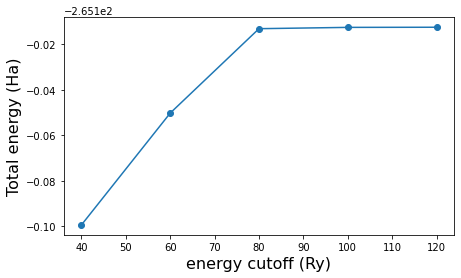

In [27]:
plt.figure(figsize=(7,4))
plt.xlabel('energy cutoff (Ry)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
energy =[results[ind].energy for ind in range(len(ecut))]
plt.plot(ecut,energy)
plt.scatter(ecut,energy)

So we observe that ecut = 80 Ry provides satisfactory converged result

In [30]:
ecut_conv = 80 # Ry
inp.set_energy_cutoff(ecut_conv)

### Convergence analysis on the lattice parameters

Now we test the convergence on the cell parameters.

First we test on the alat parameter

In [67]:
alat_span = np.linspace(-4.,1,11)
alat_span

array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ])

In [68]:
study = D.Dataset(run_dir=run_dir,num_tasks=4)

for a_span in alat_span:
    a = alat*(1+a_span/100)
    idd = {'alat' : a_span}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_lattice(ibrav=4,celldm1=a,celldm3=celldm3)
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)

Initialize a Dataset with 4 parallel tasks


In [69]:
#study.runs[4]

In [70]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10]] 

Run the task [0, 1, 2, 3] 
Skip the run of alat_-4.0
Skip the run of Skip the run of alat_-3.5
alat_-3.0
Skip the run of alat_-2.5
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of alat_-2.0 Skip the run of
Skip the run ofalat_-1.5 
alat_-1.0
Skip the run of alat_-0.5
Task [4, 5, 6, 7] ended 
 
Run the task [8, 9, 10] 
Skip the run of Skip the run ofalat_0.0 
alat_0.5
Skip the run of alat_1.0
Task [8, 9, 10] ended 
 


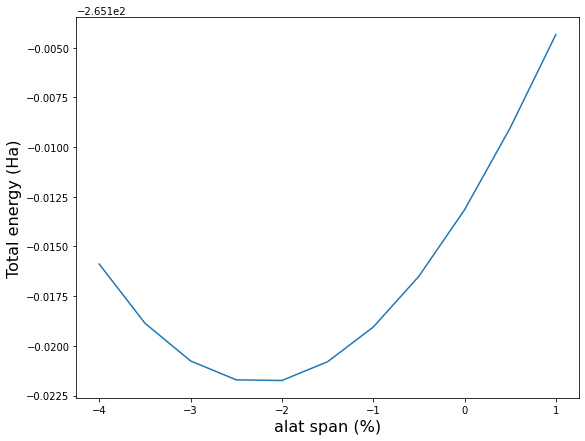

In [71]:
plt.figure(figsize=(9,7))
plt.xlabel('alat span (%)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
energy =[results[ind] for ind in range(len(alat_span))]
plt.plot(alat_span,energy)
#print(energy)

We perform a quadratic fit of the data and extract the equilibrium alat value

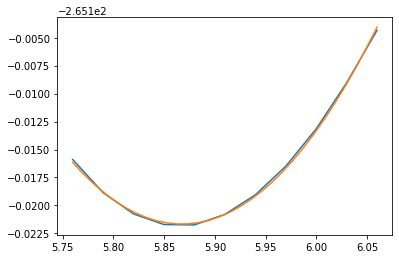

In [63]:
y =[results[ind] for ind in range(len(alat_span))]
x = [alat*(1+a/100) for a in alat_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [64]:
x_eq = -coeffs[1]/(2*coeffs[0])
x_eq

5.867495383417899

In [65]:
alat_conv = 5.8675

Now we relax the celldm(3) parameter

In [84]:
celldm3_span = np.linspace(-2.,1,7)
celldm3_span

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ])

In [85]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)

for c_span in celldm3_span:
    c = celldm3*(1+c_span/100)
    idd = {'celldm3' : c_span}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c)
    study.append_run(id=idd,input=inp,runner=code)
study.set_postprocessing_function(PP.pw_get_energy)

Initialize a Dataset with 2 parallel tasks


In [86]:
#study.runs[2]

In [88]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6]] 

Run the task [0, 1] 
Skip the run of celldm3_-2.0
Skip the run of celldm3_-1.5
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of celldm3_-1.0
Skip the run of celldm3_-0.5
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of celldm3_0.0
Skip the run of celldm3_0.5
Task [4, 5] ended 
 
Run the task [6] 
Skip the run of celldm3_1.0
Task [6] ended 
 


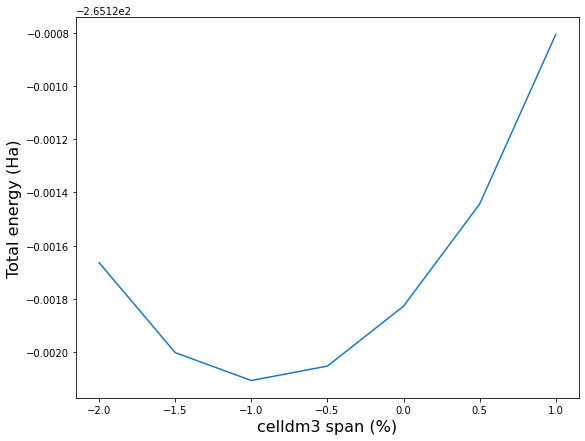

In [89]:
plt.figure(figsize=(9,7))
plt.xlabel('celldm3 span (%)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
energy =[results[ind] for ind in range(len(celldm3_span))]
plt.plot(celldm3_span,energy)
#print(energy)

We perform a quadratic fit of the data and extract the equilibrium alat value

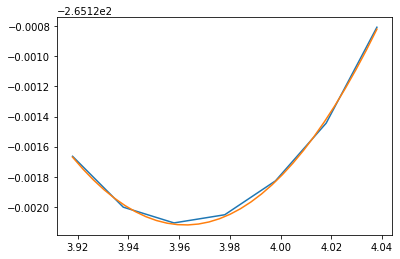

In [91]:
y =[results[ind] for ind in range(len(celldm3_span))]
x = [celldm3*(1+a/100) for a in celldm3_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [92]:
x_eq = -coeffs[1]/(2*coeffs[0])
x_eq

3.9624763811344135

In [ ]:
celldm3_conv = 3.9625

### Converged ground states

Finally we perform a last scf calculation with converged parameters

In [5]:
ecut_conv = 80 # Ry
alat_conv = 5.8675
celldm3_conv = 3.9625

inp = I.PwInput(file='Bulk_input_files/MoS2_2H_pbe_bulk.in')
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir('../pseudos')
inp.set_energy_cutoff(ecut_conv)
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=celldm3_conv)
inp.set_num_bnds(54)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'restart_mode': "'from_scratch'",
  'wf_collect': '.true.',
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 4,
  'celldm(1)': 5.8675,
  'celldm(3)': 3.9625,
  'nat': 6,
  'ntyp': 2,
  'noncolin': '.true.',
  'lspinorb': '.true.',
  'ecutwfc': 80,
  'nbnd': 54},
 'electrons': {'diago_full_acc': '.false.',
  'mixing_beta': 0.7,
  'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'S': [32.065, 'S-fr.out'], 'Mo': [183.84, 'Mo-fr.out']},
 'atomic_positions': {'type': '(crystal)',
  'values': [['Mo', [0.333333, 0.666667, 0.25]],
   ['Mo', [0.666667, 0.333333, 0.75]],
   ['S', [0.666667, 0.333333, 0.3768113548]],
   ['S', [0.333333, 0.666667, 0.8768113548]],
   ['S', [0.666667, 0.333333, 0.1231886452]],
   ['S', [0.333333, 0.666667, 0.6231886452]]]},
 'kpoints': {'type': 'automatic',
  'values': ([12.0, 12.0, 2.0], [0.0, 0.0, 0.0])},


In [140]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged'
inp.set_prefix(D.name_from_id(idd))
study.append_run(id=idd,input=inp,runner=code)
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [141]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of gs_converged
Task [0] ended 
 


In [142]:
results[0].get_gap()

Indirect gap system
Gap : 0.8481633361221252 eV
Direct gap : 1.816052952273866 eV


{'gap': 0.8481633361221252,
 'direct_gap': 1.816052952273866,
 'position_cbm': 24,
 'positon_vbm': 0,
 'positon_direct_gap': 36}

## Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [143]:
bands_prefix = 'bands'
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

In [144]:
klist = Tools.build_pw_kpath(G,Mp,Kp,G,numstep=30)
klist

[[0.0, 0.0, 0.0, 30],
 [0.0, 0.5773502691896258, 0.0, 30],
 [0.3333333333333333, 0.5773502691896258, 0.0, 30],
 [0.0, 0.0, 0.0, 0]]

In [146]:
inp.set_bands(60,force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'restart_mode': "'from_scratch'",
  'wf_collect': '.true.',
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 4,
  'celldm(1)': 5.8675,
  'celldm(3)': 3.9625,
  'nat': 6,
  'ntyp': 2,
  'noncolin': '.true.',
  'lspinorb': '.true.',
  'ecutwfc': 80,
  'nbnd': 60},
 'electrons': {'diago_full_acc': '.false.',
  'mixing_beta': 0.7,
  'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'S': [32.065, 'S-fr.out'], 'Mo': [183.84, 'Mo-fr.out']},
 'atomic_positions': {'type': '(crystal)',
  'values': [['Mo', [0.333333, 0.666667, 0.25]],
   ['Mo', [0.666667, 0.333333, 0.75]],
   ['S', [0.666667, 0.333333, 0.3768113548]],
   ['S', [0.333333, 0.666667, 0.8768113548]],
   ['S', [0.666667, 0.333333, 0.1231886452]],
   ['S', [0.333333, 0.666667, 0.6231886452]]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 30],
   [0.0, 0.577350

In [147]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='BULK-DFT_analysis/gs_converged.save')

copy source_dir BULK-DFT_analysis/gs_converged.save in the /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/BULK-DFT_analysis/bands.save
run command: mpirun -np 16 pw.x -inp bands.in > bands.log
slurm submit:  cd BULK-DFT_analysis ; sbatch job_bands.sh
computation bands is running...
computation bands ended


Once that the computation is over we can create an instance of PwBands

In [148]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [149]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.5773502657018026, 0.9106835999999987, 0.57735027])

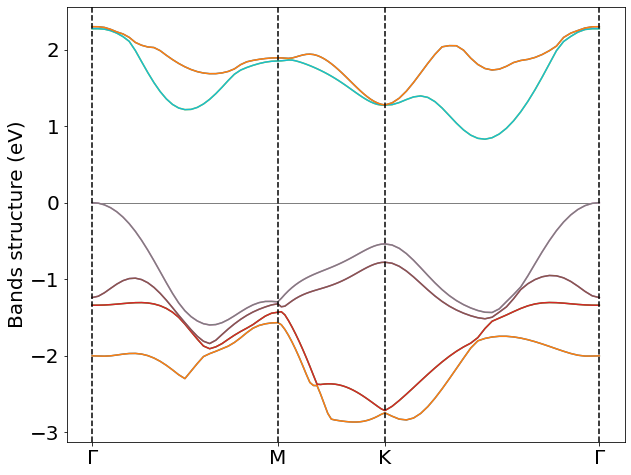

In [155]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(44,56)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

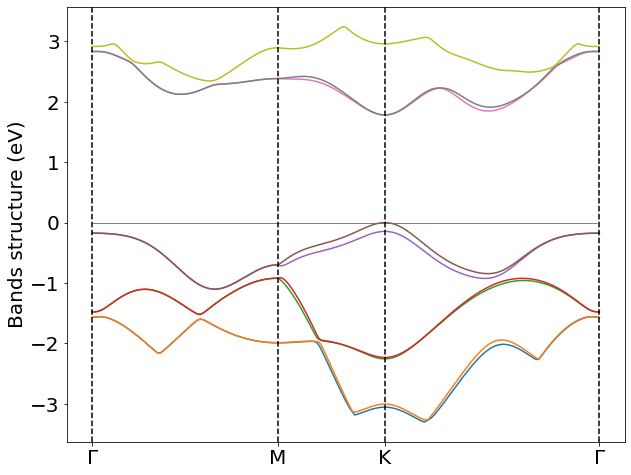

In [12]:
# single layer result
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(20,29)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

## NSCF computations on regular grids

We set up the nscf computations on regular grids.

In agreement with the results presented in PHYSICAL REVIEW B 88, 045412 (2013)
we use 200 bands

In [6]:
nbnds = 200
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)
#inp

In [7]:
kvalues = [[12,12,2],[18,18,3],[24,24,4]]

In [8]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)
study.set_postprocessing_function(PP.pw_parse_data)

for k in kvalues:
    idd = 'kpoints_%sx%sx%s-nbnds_%s'%(k[0],k[1],k[2],nbnds)
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k[0],k[1],k[2]])
    study.append_run(id=idd,input=inp,runner=code,source_dir='BULK-DFT_analysis/gs_converged.save')

Initialize a Dataset with 1 parallel tasks


In [9]:
study.runs[2]

{'label': 'Dataset',
 'run_dir': 'BULK-DFT_analysis',
 'num_tasks': 1,
 'verbose': True,
 'input': {'control': {'calculation': "'nscf'",
   'verbosity': "'high'",
   'prefix': "'kpoints_24x24x4-nbnds_200'",
   'outdir': "'./'",
   'restart_mode': "'from_scratch'",
   'wf_collect': '.true.',
   'pseudo_dir': "'../pseudos'"},
  'system': {'force_symmorphic': '.true.',
   'ibrav': 4,
   'celldm(1)': 5.8675,
   'celldm(3)': 3.9625,
   'nat': 6,
   'ntyp': 2,
   'noncolin': '.true.',
   'lspinorb': '.true.',
   'ecutwfc': 80,
   'nbnd': 200},
  'electrons': {'diago_full_acc': '.false.',
   'mixing_beta': 0.7,
   'conv_thr': 1e-06},
  'ions': {},
  'cell': {},
  'atomic_species': {'S': [32.065, 'S-fr.out'], 'Mo': [183.84, 'Mo-fr.out']},
  'atomic_positions': {'type': '(crystal)',
   'values': [['Mo', [0.333333, 0.666667, 0.25]],
    ['Mo', [0.666667, 0.333333, 0.75]],
    ['S', [0.666667, 0.333333, 0.3768113548]],
    ['S', [0.333333, 0.666667, 0.8768113548]],
    ['S', [0.666667, 0.333333, 

In [ ]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of kpoints_12x12x2-nbnds_200
The folder /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/BULK-DFT_analysis/kpoints_12x12x2-nbnds_200.save already exists. Source_dir BULK-DFT_analysis/gs_converged.save not copied
Task [0] ended 
 
Run the task [1] 
Skip the run of kpoints_18x18x3-nbnds_200
The folder /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/BULK-DFT_analysis/kpoints_18x18x3-nbnds_200.save already exists. Source_dir BULK-DFT_analysis/gs_converged.save not copied
Task [1] ended 
 
Run the task [2] 
copy source_dir BULK-DFT_analysis/gs_converged.save in the /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/BULK-DFT_analysis/kpoints_24x24x4-nbnds_200.save
run command: mpirun -np 16 pw.x -inp kpoints_24x24x4-nbnds_200.in > kpoints_24x24x4-nbnds_200.log
slurm submit:  cd BULK-DFT_analysis ; sbatch job_kpoints_24x24x4-nbnds_200.sh
computation kpoints_24x24x4-nb